# Project 7 - Logistic Regression and Support Vector Machines

## Notebook imports and settings

In [1]:
# Python imports
import glob
import random as rn
import tqdm

# Numerical imports
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix

# Tensorflow imports
import tensorflow as tf

# Keras imports
import tensorflow.keras.backend as K
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import lecun_normal, glorot_normal, he_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Input, Flatten, LayerNormalization
from tensorflow.keras.optimizers import Adam, Adagrad, SGD, Nadam
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.utils import Sequence, get_custom_objects, to_categorical
from optimizer import *

# Plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import precision_recall_fscore_support
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import tree

from graphviz import Source

from sklearn.tree import export_graphviz
from IPython.display import SVG

# Plotting settings
sns.set()
sns.set_palette("colorblind")
sns.set_style("ticks")

# Seed randomness
rn.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

# Progress bars
# !pip install tensorflow_addons
from tensorflow_addons.callbacks import TQDMProgressBar

## Load and format data

In [2]:
def convert_to_csv(folder):
    with open(f"./data/{folder}.csv", "w+") as fout:
        print("class,del1,del2,x1,y1,x2,y2,size,diag", file=fout)
        
        for file_name in tqdm_notebook(glob.glob(f"./data/{folder}/*"), desc=f"{folder}"):
            for line in open(file_name):
                line = line.split()
                line = ",".join(line)
                print(line, file=fout)
                
    df = pd.read_csv(f"./data/{folder}.csv")
    df = df.drop(["del1", "del2"], axis=1)
    df[["class"]] = df[["class"]] - 1
    df.to_csv(f"./data/{folder}.csv", index=False)

# convert_to_csv("train")
# convert_to_csv("test")

# Yes, they are flipped
train = pd.read_csv("./data/test.csv").sample(frac=1.0)
test = pd.read_csv("./data/train.csv").sample(frac=1.0)

# Split data into target and predictors
x_train = train.drop("class", axis=1)
y_train = to_categorical(train[["class"]])

x_test = test.drop("class", axis=1)
y_test = to_categorical(test[["class"]])

# Normalize input
x_train = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(preprocessing.MinMaxScaler().fit_transform(x_test), columns=x_test.columns)

print(f"Train rows: {x_train.shape[0]}")
print(f"Train cols: {x_train.shape[1]}")
print()
print(f"Test rows:  {x_test.shape[0]}")
print(f"Test cols:  {x_test.shape[1]}")

Train rows: 25545
Train cols: 6

Test rows:  5109
Test cols:  6


## Build a Keras model

In [3]:
def build_model():
    model = Sequential(name="DigitClassifier")

    # Input layers
    model.add(Input(shape=(6,)))
    model.add(Flatten())
    model.add(Dense(6, activation="relu", kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform()))
    
    # Hidden layers
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(1e-4), kernel_initializer=he_uniform()))
    model.add(Dense(256, activation="relu", kernel_regularizer=l2(1e-2), kernel_initializer=he_uniform()))
    model.add(Dropout(0.25))
    
    # Output layers
    model.add(Dense(10, activation="softmax"))

    # Compilation
    optimizier = NadamWithWeightnorm(learning_rate=1e-4, decay=1e-4, clipvalue=.5)
    model.compile(optimizer=optimizier, loss="categorical_crossentropy", metrics=["categorical_accuracy"])
    model.summary()
    
    return model

## Train the Neural Network

Model: "DigitClassifier"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 6)                 42        
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1792      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
Total params: 70,196
Trainable params: 70,196
Non-trainable params: 0
_______________________________________________

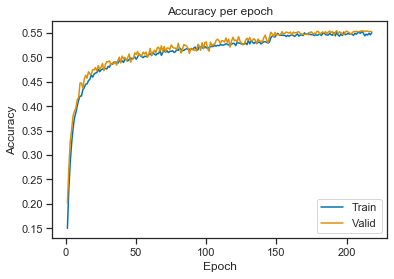

Train Loss:     1.0572
Valid Loss:     1.0469
Test  Loss:     1.0485

Train Accuracy: 0.5506
Valid Accuracy: 0.5524
Test  Accuracy: 0.5533

Wall time: 17min 7s


In [4]:
%%time

# Store the best model based on val_accuracy and stop when no improvements are made
early_stopping = EarlyStopping(
    monitor="val_categorical_accuracy",
    verbose=0,
    patience=25,
    restore_best_weights=True
)

# Reduce the learning rate when a plateau is encountered
rlrop = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=10)

# Network and traning hyperparameters
batch_size = 16 
epochs = 250

model = build_model()
# model.load_weights("model.h5")
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=0,
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        early_stopping,
        rlrop,
        TQDMProgressBar(show_epoch_progress=False),
    ]
)
# model.save_weights("model.h5")

y1 = history.history["categorical_accuracy"]
y2 = history.history["val_categorical_accuracy"]
x = list(range(1, len(y1) + 1))
sns.lineplot(x, y1)
sns.lineplot(x, y2)

plt.title("Accuracy per epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(["Train", "Valid"], loc="lower right")
plt.savefig("./images/accuracy_per_epoch_nn.png", bbox_inches="tight")
plt.show()

score = model.evaluate(x_test, y_test, verbose=0)
print(f"Train Loss:     {history.history['loss'][-1]:.4f}")
print(f"Valid Loss:     {history.history['val_loss'][-1]:.4f}")
print(f"Test  Loss:     {score[0]:.4f}")
print()

print(f"Train Accuracy: {history.history['categorical_accuracy'][-1]:.4f}")
print(f"Valid Accuracy: {history.history['val_categorical_accuracy'][-1]:.4f}")
print(f"Test  Accuracy: {score[1]:.4f}")
print()

## Construct a confusion-matrix for our Neural Network

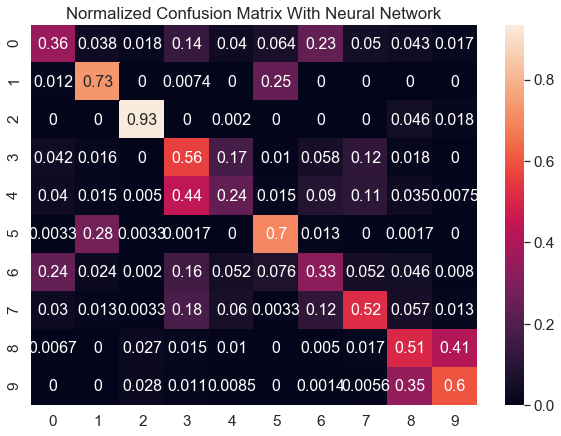

In [5]:
pred = model.predict(x_test)

y_true, y_pred = [], []
for index, row in enumerate(pred):
    y_pred.append(np.argmax(row))
    y_true.append(np.argmax(y_test[index]))

matrix = confusion_matrix(y_true, y_pred)
matrix = preprocessing.normalize(matrix.astype(np.float64), axis=1, norm="l1")
df_cm = pd.DataFrame(matrix, index=[i for i in range(10)], columns=[i for i in range(10)])

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})
plt.title("Normalized Confusion Matrix With Neural Network")
plt.savefig("./images/normalized_confusion_matrix_nn.png", bbox_inches="tight")
plt.show()

In [ ]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
display(train)

In [ ]:
feature_cols = ['x1', 'y1', 'x2', 'y2', 'size', 'diag']
X = test[feature_cols]
y = test[["class"]]

treeclf = DecisionTreeClassifier(max_depth=5, random_state=3)
treeclf.fit(X, y)

graph = Source(tree.export_graphviz(treeclf, out_file=None,
                                    feature_names=feature_cols,
#                                     class_names=['0', '1'], filled = True))
                                    class_names=['1', '2', '3', '4', '5', '6', '7', '8', '9', '10'], filled = True))
svg = SVG(graph.pipe(format='svg'))
display(svg)

plt.figure()
plot_tree(treeclf, filled=True)
plt.show()